# Dreambooth Personalized Image Generation

## Setup and Installation


**Important**: We need to clone this forked diffusers repo, as it contains additional arguments / modifications to improve the results

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [1]:
# Install diffusers
!git clone https://github.com/ShivamShrirao/diffusers

%cd diffusers/
!pip install -e .

# For GPU efficiency
!pip install bitsandbytes

# Install dreambooth requirements
%cd /content/diffusers/examples/dreambooth/
!pip install -r requirements.txt

# Accelerate environment
!accelerate config default

Cloning into 'diffusers'...
remote: Enumerating objects: 20186, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 20186 (delta 0), reused 0 (delta 0), pack-reused 20185
Receiving objects: 100% (20186/20186), 24.84 MiB | 21.16 MiB/s, done.
Resolving deltas: 100% (13421/13421), done.
/content/diffusers
Obtaining file:///content/diffusers
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for diffusers (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.15.0.dev0-0.editable-py3-none-any.whl size=11075 sha256=181c6f06aadf54e49bd29a91ba40b0c33228827d264fd2890bad914a38f34828
  Stored in directory: /tmp/pip-ephem-wheel-cache-kln5t4dn/wheels/95/c5/3b/e1b4269f8a2584de57e75f949a185b48fc4144e9a91fc9965a
Successfully built diffusers
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/

In [2]:
!nvidia-smi

Thu May 16 13:19:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Time to upload the samples

In [5]:
!pip install --upgrade diffusers[torch]


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 14.7 MB/s eta 0:00:00
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.15.0.dev0
    Uninstalling diffusers-0.15.0.dev0:
      Successfully uninstalled diffusers-0.15.0.dev0


In [6]:
%cd /content
print("Make sure you put the images into the newly created directory!")
!mkdir images

/content
Make sure you put the images into the newly created directory!


## Fine-tuning

### Explanation of the most important args:

| Argument | Description |
| --- | --- |
| instance_data_dir | Directory of the sample images |
| instance_prompt | Prompt with the special token like [V], zwx, sks... |
| with_prior_preservation | Used to avoid overfitting and language-drift |
| num_class_images | Number of generated images (prior) |
| class_prompt | Used together with prior preservation - type of generated samples to avoid prior loss |
| use_8bit_adam | Quantized optimizer to reduce GPU memory (from bitsandbytes using reduced precision) |
| mixed_precision | Another accelerator to reduce data type precision |
| pretrained_vae_name_or_path | Custom autoencoder to improve eyes and faces |


- There are also other scripts like train_dreambooth_lora.py
- The actual values are based on a mix of experimentation and different diffusers tutorials



In [10]:
%cd /content
%env MODEL_NAME=runwayml/stable-diffusion-v1-5
%env INSTANCE_DIR=/content/images/
%env OUTPUT_DIR=/outputs
%env CLASS_DIR=/content/diffusers/examples/dreambooth/person/


!accelerate launch /content/diffusers/examples/dreambooth/train_dreambooth.py \
    --pretrained_model_name_or_path=$MODEL_NAME  \
    --pretrained_vae_name_or_path="stabilityai/sd-vae-ft-mse" \
    --instance_data_dir=$INSTANCE_DIR \
    --output_dir=$OUTPUT_DIR \
    --class_data_dir=$CLASS_DIR \
    --with_prior_preservation --prior_loss_weight=1.0 \
    --instance_prompt="photo of zwx floral pattern" \
    --class_prompt="floral patterns" \
    --resolution=512 \
    --train_batch_size=1 \
    --gradient_accumulation_steps=1 --gradient_checkpointing \
    --use_8bit_adam \
    --mixed_precision="fp16" \
    --learning_rate=1e-6 \
    --lr_scheduler="constant" \
    --lr_warmup_steps=0 \
    --num_class_images=300 \
    --max_train_steps=1000

/content
env: MODEL_NAME=runwayml/stable-diffusion-v1-5
env: INSTANCE_DIR=/content/images/
env: OUTPUT_DIR=/outputs
env: CLASS_DIR=/content/diffusers/examples/dreambooth/person/
2024-05-16 14:02:23.684356: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-16 14:02:23.684432: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-16 14:02:23.686624: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-16 14:02:25.416655: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/diffusers/configuration

## Generation

In [ ]:
# Ugly hack, I'm too stupid to import StableDiffusionPipeline from local installation
# If you manage to fix this, let me know :)
!pip uninstall diffusers -y
!pip install diffusers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 12.8 MB/s eta 0:00:00


- Ideas for better prompts: https://stablediffusionweb.com/prompts

In [16]:
%cd /content
import torch
import random
from diffusers import StableDiffusionPipeline

model_id = "/content/drive/MyDrive/outputs/1000"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to("cuda")

example_prompts = [
"photo of zwx floral colorful patterns on kurta",
"beautiful fresh xyz dull floral patterns on kurta",
"aws colorful floral patterns on kurta ",
"spring colorful flower patterns on zwx kurta",
"photo of zwx floral colorful patterns on kurta",
"beautiful fresh yxz floral patterns on kurta",
"photo of aqs emroidered patterns on kurta",
"beautiful emroidered patterns on kurta",
"amb emroidered design pattern  ",
"detailed aqs emroidered design on kurta",
"emroidered patterns on kurta",

]

num_images = 10
for i in range(num_images):
    prompt = example_prompts[random.randint(0, len(example_prompts) - 1)]
    image = pipe(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]
    image.save(f"profile_{i}.png")

/content


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/content


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Enter your prompt (or type 'quit' to exit): embroidered design on kurta


  0%|          | 0/50 [00:00<?, ?it/s]

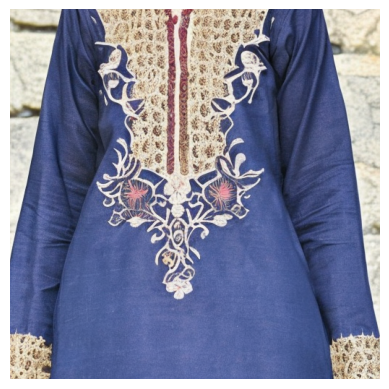

In [ ]:
%cd /content
import torch
import random
from PIL import Image
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt

# Load the model
model_id = "/content/drive/MyDrive/outputs/1000"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to("cuda")

# Function to generate and display image based on prompt
def generate_and_display_image(prompt):
    image = pipe(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Main loop
while True:
    # Get user prompt
    user_prompt = input("Enter your prompt (or type 'quit' to exit): ")

    # Check if user wants to quit
    if user_prompt.lower() == 'quit':
        print("Exiting...")
        break

    # Generate and display image
    generate_and_display_image(user_prompt)
